In [1]:
from music21 import stream, interval,instrument, corpus, converter
from music21 import note, chord, clef, environment, duration, meter
import notebook
import pandas as pd
import pathlib
import numpy as np
import operator, copy, random
from datetime import date, timedelta
import argparse

In [3]:
class Utils(object):
    
    @staticmethod
    def get_score(self, file_path:str) -> stream.Score:
        score = None
        file_info = music.Utils.get_file_info(file_path)
        if file_info['Path'].exists():
                score = converter.parse(file_info['path_text'])
        return score
    
    #
    # get intervals for a Part
    #
    @staticmethod
    def get_part_intervals(apart)-> [dict]:
        intrvals = []
        part_notes = apart.flat.getElementsByClass('Note')
        for ind in range(len(part_notes)-1):
            n1 = part_notes[ind]
            n2 = part_notes[ind+1]
            i = interval.Interval(n1, n2)
            idict = {'note1':n1, 'note2':n2, 'interval':i}
            intrvals.append(idict)
        return intrvals
    
    @staticmethod
    def get_part_notes(apart) -> [note.Note]:
        part_notes = apart.flat.getElementsByClass('Note')
        return part_notes
    
    @staticmethod
    def get_score_intervals(ascore, partname=None):
        """ Get the intervals for all Parts of a Score as a dict
        
        """
        parts = ascore.getElementsByClass(stream.Part)
        pdict = dict()
        for p in parts:
            pname = p.partName
            if partname is None or pname==partname:
                pdict[pname] = Utils.get_part_intervals(p)
        return pdict
    
    @staticmethod
    def get_score_notes(ascore, partname=None):
        """Get the Notes for all Parts or the named part of a Score as a dict
        
        Note that this does not return Rest or Chord objects
        """
        
        parts = ascore.getElementsByClass(stream.Part)
        pdict = dict()
        for p in parts:
            pname = p.partName
            if partname is None or pname==partname:
                notes = Utils.get_part_notes(p)
                pdict[pname] = notes
        return pdict
    
    
    @staticmethod
    def get_intervals_for_score(ascore:stream.Score, partnames:[str]=None, partnumbers:[int]=None) ->  (pd.DataFrame,[str],[int]):
        """Get the intervals of all Parts of a Score as a pandas.DataFrame
        
        DataFrame columns returned:
            interval  (interval.Interval)
            part_name
            part_number
            note1  (note.Note the first Note in the interval pair)
            note2  (note.Note the second Note in the interval pair)
            name (interval name as in "P5")
            directedName  (as in "P-5" for down a 5th)
            niceName
            semitones (int)
        
        Returns a 3-tuplet consisting of the intervals_df DataFrame,
        a [int] of part numbers, and a [str] of part names.
        """
        pdict = Utils.get_score_intervals(ascore)
        intrvals_df = pd.DataFrame()
        part_number = 1
        score_partnames = set()
        score_partnumbers = set()
        for k in pdict.keys():  # part names
                if (partnames is None or k in partnames) or (partnumbers is None or part_number in partnumbers):
                    part_intervals = pdict[k]
                    intervals =  [x['interval'] for x in part_intervals]
                    df = pd.DataFrame(data=intervals, columns=['interval'])
                    df['part_number'] = part_number
                    df['part_name'] = k
                    df['note1'] = [x['note1'] for x in part_intervals]
                    df['note2'] = [x['note2'] for x in part_intervals]
                    score_partnames.add(k)
                    score_partnumbers.add(part_number)
                    intrvals_df = intrvals_df.append(df)
                    part_number = part_number + 1
    
        intrvals_df['name'] = [x.name for x in intrvals_df['interval']]
        intrvals_df['directedName'] = [x.directedName for x in intrvals_df['interval']]
        intrvals_df['niceName'] = [x.niceName for x in intrvals_df['interval']]
        intrvals_df['semitones'] = [x.semitones for x in intrvals_df['interval']]
        return intrvals_df, score_partnames, score_partnumbers
    
    @staticmethod
    def get_notes_for_score(ascore, partnames=None, partnumbers=None):
        """Get the Notes of all Parts from a score as a pandas.DataFrame
        
        DataFrame columns returned:
            part_name
            part_number
            Note (music21.note.Note)
            name
            nameWithOctave
            pitch (music21.pitch.Pitch)
            duration (music21.duration.Duration)
            pitchClass (int)
        
        Returns a 3-tuplet consisting of the notes_df DataFrame,
        an interger list of part numbers, and a str list of part names.
        """
        pdict = Utils.get_score_notes(ascore)
        notes_df = pd.DataFrame()
        part_number = 1
        score_partnames = set()
        score_partnumbers = set()
        for k in pdict.keys():
            if (partnames is None or k in partnames) or (partnumbers is None or part_number in partnumbers):
                df = pd.DataFrame(data=pdict[k], columns=['note'])
                df['part_number'] = part_number
                df['part_name'] = k
                score_partnames.add(k)
                score_partnumbers.add(part_number)
                notes_df = notes_df.append(df)
                part_number = part_number + 1
        
        notes_df['name'] = [x.name for x in notes_df['note']]
        notes_df['nameWithOctave'] = [x.nameWithOctave for x in notes_df['note']]
        notes_df['pitch'] = [x.pitch for x in notes_df['note']]
        notes_df['duration'] = [x.duration for x in notes_df['note']]
        notes_df['pitchClass'] = [x.pitch.pitchClass for x in notes_df['note']]
        return notes_df, score_partnames, score_partnumbers
    
    @staticmethod
    def get_durations_from_notes(source_df:pd.DataFrame) -> pd.DataFrame:
        """Get the Durations from a notes or intervals DataFrame
        
        The notes_df argument has the columns described in get_notes_for_score().
        DataFrame columns returned:
            Note (music21.note.Note)
            duration (music21.duration.Duration)
            type
            ordinal
            dots
            fullName
            quarterLength
            tuplets
        See the music21.duration documentation for details on individual fields
        """
        if 'duration' in source_df.columns:
            notes_df = source_df
            durations_df = pd.DataFrame(data=notes_df[['note','duration']], columns=['note','duration'])
            durations_df['type'] = [x.type for x in notes_df['duration']]
            durations_df['ordinal'] = [x.ordinal for x in notes_df['duration']]
            durations_df['dots'] = [x.dots for x in notes_df['duration']]
            durations_df['fullName'] = [x.fullName for x in notes_df['duration']]
            durations_df['quarterLength'] = [x.quarterLength for x in notes_df['duration']]
            durations_df['tuplets'] = [x.tuplets for x in notes_df['duration']]
        else:
            intervals_df = source_df
            durations_df = pd.DataFrame(data=intervals_df[['note1']], columns=['note1'])
            durations_df['duration'] = [x.duration for x in intervals_df['note1']]
            durations_df['type'] = [x.duration.type for x in intervals_df['note1']]
            durations_df['ordinal'] = [x.duration.ordinal for x in intervals_df['note1']]
            durations_df['dots'] = [x.duration.dots for x in intervals_df['note1']]
            durations_df['fullName'] = [x.duration.fullName for x in intervals_df['note1']]
            durations_df['quarterLength'] = [x.duration.quarterLength for x in intervals_df['note1']]
            durations_df['tuplets'] = [x.duration.tuplets for x in intervals_df['note1']]
            durations_df.rename(columns={'note1':'note'}, inplace=True)
        return durations_df
    
    @staticmethod
    def get_metadata_bundle(composer=None, title=None):
        meta = None
        if composer is not None:
            meta = corpus.search(composer,'composer')
            if title is not None:
                meta = meta.intersection(corpus.search(title,'title'))
        elif title is not None:
            meta = corpus.search(title,'title')
        return meta
        
    @staticmethod
    def get_all_score_intervals(composer=None, title=None, partnames=None, partnumbers=None):
        meta = Utils.get_metadata_bundle(composer, title)
        intrvals_df = pd.DataFrame()
        all_score_partnames = set()
        all_score_partnumbers = set()
        for i in range(len(meta)):
            md = meta[i].metadata
            score = corpus.parse(meta[i])
            df,pnames,pnums = Utils.get_intervals_for_score(score, partnames, partnumbers)
            df['title'] = md.title
            intrvals_df = intrvals_df.append(df)
            all_score_partnames = all_score_partnames.union(pnames)
            all_score_partnumbers = all_score_partnumbers.union(pnums)
        return intrvals_df, all_score_partnames, all_score_partnumbers

    @staticmethod
    def get_all_score_notes(composer=None, title=None, partnames=None, partnumbers=None):
        meta = Utils.get_metadata_bundle(composer, title)
        notes_df = pd.DataFrame()
        all_score_partnames = set()
        all_score_partnumbers = set()
        for i in range(len(meta)):
            md = meta[i].metadata
            score = corpus.parse(meta[i])
            df,pnames,pnums = Utils.get_notes_for_score(score, partnames, partnumbers)
            df['title'] = md.title
            notes_df = notes_df.append(df)
            all_score_partnames = all_score_partnames.union(pnames)
            all_score_partnumbers = all_score_partnumbers.union(pnums)
        return notes_df, all_score_partnames, all_score_partnumbers

    @staticmethod
    def show_measures(measures, how='text'):
        nmeasures = len(measures)
        print(f"number of measures: {nmeasures}")
        i = 1
        for measure in measures:
            notes = measure.getElementsByClass(['Note','Chord','Rest'])
            print('measure {}'.format(i))
            for n in notes:
                if n.isNote:
                    print(n.nameWithOctave)
                else:
                    print(n.fullName)
            i = i+1
            measure.show(how)   # if None, displays in MuseScore
    
    @staticmethod
    def show_intervals(df, what='name'):
        int_string = str(df[what].values.tolist())
        return int_string
    
    @staticmethod
    def show_notes(df, what='name'):
        note_string = str(df[what].values.tolist())
        return note_string
    
    @staticmethod
    def show_durations(df, what='quarterLength'):
        duration_string = str(df[what].values.tolist())
        return duration_string
    
    @staticmethod
    def note_info(note):
        dur = note.duration
        if note.isRest:
            info = f'name: {note.name}, fullName: {note.fullName}, type: {dur.type}, dots: {dur.dots},\
            quarterLength: {dur.quarterLength}'
        else:
            info = f'{note.nameWithOctave}, type: {dur.type}, dots: {dur.dots},\
            fullName: {dur.fullName}, quarterLength: {dur.quarterLength}, tuplets: {dur.tuplets}'
        return info

    @staticmethod
    def duration_info(dur):
        info = f"type: {dur.type}, ordinal: {dur.ordinal}, dots: {dur.dots}, fullName: {dur.fullName}, quarterLength: {dur.quarterLength}, tuplets: {dur.tuplets}"
        return info
    
    @staticmethod
    def get_interval_stats(ascore, partnames=None, partnumbers=None):
        int_df,pnames,pnums = Utils.get_intervals_for_score(ascore, partnames, partnumbers)
        int_df = int_df.groupby(by=['semitones']).count()[['interval']]
        int_df.rename(columns={'interval':'count'}, inplace=True)
        int_df.reset_index(inplace=True)       
        return int_df.sort_values(by='count', ascending=False)
    
    @staticmethod
    def create_note(start_note:note.Note, 
                    anInterval:interval.Interval=None, semitones:int=None,
                    dur:duration.Duration=None, quarterLen:int=None) -> note.Note:
        """Creates a new Note a given interval away from a starting note
        
        Args:
            start_note (note.Note): the anchor Note
            interval (interval.Interval): a valid Interval or None. If None, semitones must be present.
            semitones (int): interval expressed as semitones
            duration (duration.Duration): duration to assign to the new Note
            quarterLength (int): duration to assign to the new Note expressed as quarterLength
        Returns:
            A new Note that is the specified interval away from the start_note.
        Notes:
            * duration or quarterLength may be specified, but not both.
            * if both duration and quarterLength are none, the duration of the new Note
              will be the same as the duration of start_note
        """
        new_note = copy.copy(start_note)    # shallow copy
        if anInterval is None and semitones is None:
            raise ValueError('interval and semitones cannot both be None')
        intval = anInterval
        if anInterval is None:
            intval = interval.Interval(semitones)
        new_note = new_note.transpose(intval)
        if dur is None and quarterLen is not None:
            new_note.quarterLength = quarterLen
        elif dur is not None:
            new_note.duration = dur
        return new_note
    
    @staticmethod
    def random_notes(lower_ps:int, upper_ps:int, num:int=10, minval=0.5) -> [note.Note]:
        notes = []
        for n in range(num):
            ps = random.randrange(lower_ps,upper_ps)    # random pitch (ps value)
            dur = random.randrange(1, 8) * minval       # random durations as quarterLength
            notes.append(note.Note(ps=ps, quarterLength=dur))
        return notes
    
    @staticmethod
    def random_part(lower_ps:int, upper_ps:int, num:int=10, minval=0.5, 
                     clef=clef.TrebleClef(), instrument=instrument.Piano()):
        # minval is given as quarterLength, 0.5 is an eighth note, 0.25 is a 16th etc.
        part = stream.Part()
        part.insert(0,instrument)
        notes = []
        notes.append(clef)
        for n in range(num):
            ps = random.randrange(lower_ps,upper_ps)    # random pitch (ps value) c4 to b6
            dur = random.randrange(1, 8) * minval    # random durations (multiples of 16th notes) as quarterLength
            notes.append(note.Note(ps=ps, quarterLength=dur))
        part.append(notes)
        return part
    
    #
    # breaks up a path name into component parts
    #
    @staticmethod
    def get_file_info(cpath, def_extension='mxl'):
        known_extensions = [def_extension, 'mxl','.xml','.musicxml']
        x = cpath.split("/")
        paths = x[0:len(x)-1]
        filename = x[-1]
        ext = filename.split(".")
        name = ext[0]
        if len(ext)==2 and ext[1] in known_extensions:
            ext = ext[1]
            path = cpath      
        else:
            ext = def_extension
            filename = f"{filename}.{ext}"
            path = f"{cpath}.{ext}"
        p = pathlib.Path(path)
        return  {'paths':paths, 'path_text':path, 'filename':filename, 'name':name,'extension': ext, 'Path':p}

    @staticmethod
    def round_values(x, places=5):
        if not type(x) is str:
            return round(x, places)
        else:
            return x
    
    @staticmethod
    def get_timedelta(start_date=date(1970,1,1), end_date=date.today()) -> int:
        """Gets the number of elapsed seconds between two dates.
        
        Args:
            start_date (datetime.date): the starting date. Default value is Jan 1,1970
            end_date: the ending date. Default value is today()
        Returns:
            The absolute value of the number of elapsed seconds between the two dates.
        Notes:
            Useful in setting a random seed.
        
        """
        
        delta = end_date - start_date
        return abs(int(delta.total_seconds()))


In [3]:
n = note.Note(nameWithOctave='Eb4', quarterLength=0.5)
n.fullName
new_note = Utils.create_note(n, semitones=2)
print('{}\t{}'.format(new_note, new_note.duration))

new_note = Utils.create_note(n, semitones=2, quarterLen=1)
print('{}\t{}'.format(new_note, new_note.duration))

interval = interval.Interval(7)
duration = duration.Duration(type='half', dots=2)
new_note = Utils.create_note(n, anInterval=interval, dur=duration )
print('{}\t{}'.format(new_note, new_note.duration))


<music21.note.Note F>	<music21.duration.Duration 0.5>
<music21.note.Note F>	<music21.duration.Duration 1.0>
<music21.note.Note B->	<music21.duration.Duration 3.5>


In [99]:
#
# steps in creating a score from Notes, Durations and part names
# First create Parts corresponding to instruments
#
p1 = stream.Part()
p1_instrument = instrument.Clarinet()    # user provides instrument name(s) in the Producer
p1.insert(0,p1_instrument)
print(p1_instrument.instrumentSound)
print(p1_instrument.midiProgram)

p2 = stream.Part()
p2_instrument = instrument.Oboe()
p2.insert(0,p2_instrument)
print(p2_instrument.midiProgram)

wind.reed.clarinet
71
68


In [8]:
notes = []
c1 = clef.BassClef()
notes.append(c1)
notes.append(note.Note('C4',quarterLength=0.5))
notes.append(note.Note('D4',quarterLength=1.5))
notes.append(note.Note('Eb4',quarterLength=1.5))
notes.append(note.Note('F4',quarterLength=1.0))
notes.append(note.Note('G4',quarterLength=1.0))
notes.append(note.Rest())    # quarter rest
notes.append(note.Note('Ab4',quarterLength=0.333333))
notes.append(note.Note('A4',quarterLength=0.333333))
notes.append(note.Note('Bb4',quarterLength=0.333333))
notes.append(note.Note('C5',quarterLength=2.0))
notes.append(note.Rest(quarterLength=2.5))
p1.append(notes)

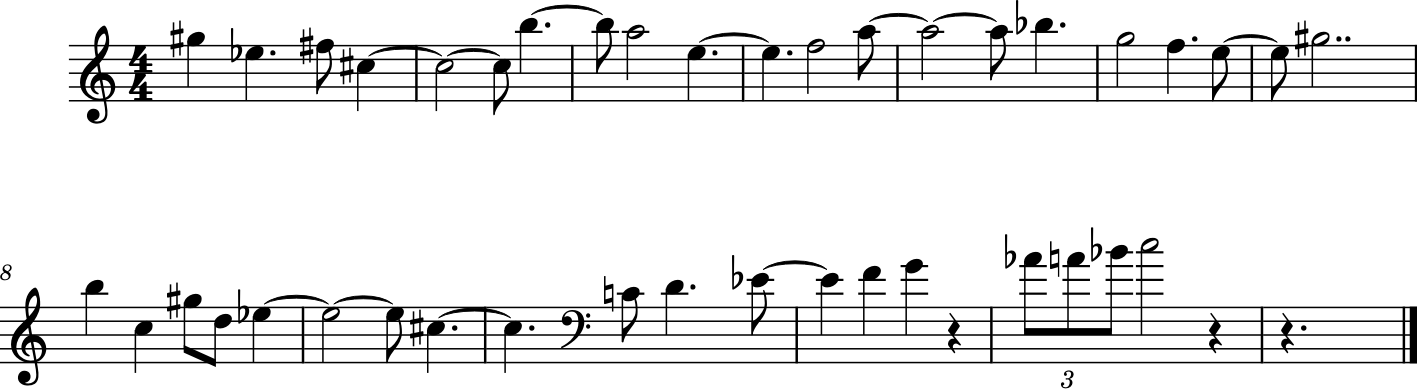

In [11]:
p1.show()

In [102]:
p1.show(fmt='midi')

In [52]:
random.randrange(60,85)    # random pitch (ps value) c4 to b6

78

In [63]:
random.randrange(1, 8) * 0.25    # random durations as multiples of 16th notes quarterLength

0.75

In [5]:
#
# Random score
# specifying the clef is unneccessary as music21 picks the best cleff for the notes
#
p1 = stream.Part()
p1_instrument = instrument.Instrument(instrumentName='Soprano')    # user provides instrument name(s) in the Producer
p1_clef = clef.TrebleClef()
p1.insert(p1_clef)
p1.insert(p1_instrument)

p2 = stream.Part()
p2_instrument = instrument.Instrument(instrumentName='Bass') 
p2_clef = clef.BassClef()
p2.insert(p2_clef)
p2.insert(p2_instrument)

random.seed(Utils.get_timedelta())
p1_notes = []
p2_notes = []

notes_list1 = Utils.random_notes(72, 85, 20)
p1_notes.append(notes_list1)
notes_list2 = Utils.random_notes(40, 62, 20)
p2_notes.append(notes_list2)

p1.append(notes_list1)
p2.append(notes_list2)
score = stream.Score()
score.append(p1)
score.append(p2)

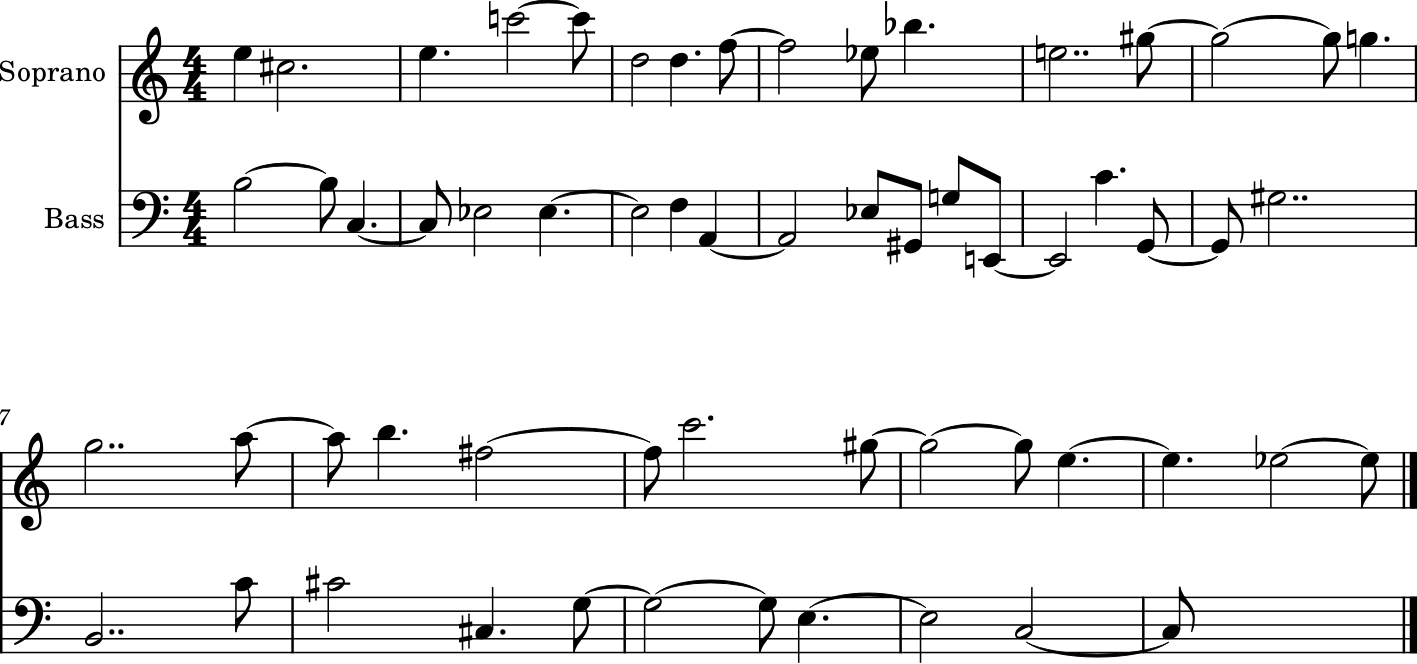

In [6]:
score.show()

In [7]:
score.show(fmt='midi')

In [42]:
score.show('musicxml')   # displays the score in MuseScore where it can be saved

In [8]:
part = Utils.random_part(42, 55, 20, minval=0.25, clef=clef.BassClef(), instrument=instrument.Clarinet())

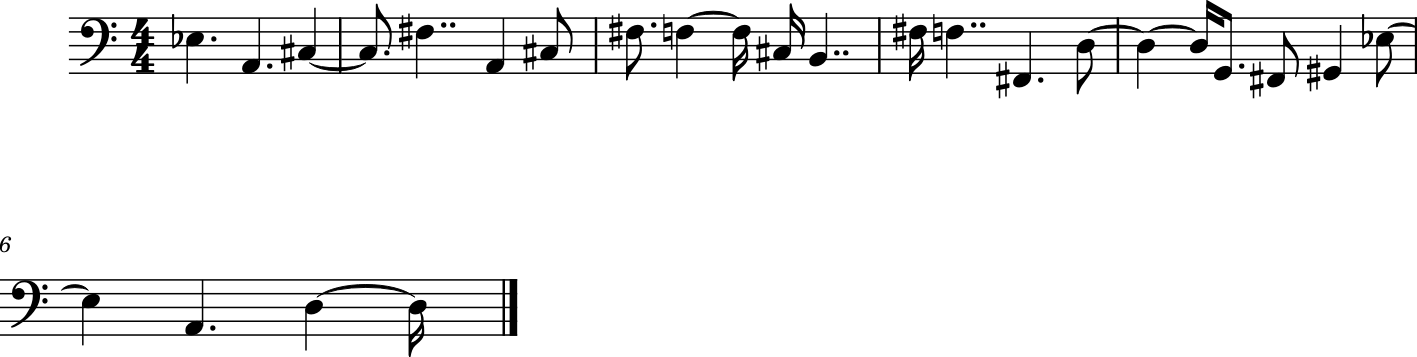

In [9]:
part.show()

In [10]:
part.show('midi')

In [33]:
parser = argparse.ArgumentParser()
parser.add_argument('--foo',  action="extend", nargs="+", type=str, choices=['c1','c2','c3','c4'], default=['c1'])
parser.add_argument("--num", type=int)
args = parser.parse_args("--num 1 --foo c1 --foo c4".split())
print(set(args.foo))

{'c1', 'c4'}


In [4]:
instrument1 = instrument.Instrument(instrumentName='Soprano')
instrument2 = instrument.Soprano()
instrument2.classes

('Soprano',
 'Vocalist',
 'Instrument',
 'Music21Object',
 'ProtoM21Object',
 'object')

In [16]:
ts = meter.TimeSignature('5/4')
num_measures = 20
print(ts.numerator)
print(ts.beatDuration.quarterLength)
total_duration = num_measures * ts.numerator * ts.beatDuration.quarterLength
print(total_duration)    # duration of all measures in quarter lengths

5
1.0
100.0
100
